### Pyspark Connection

### Load Libraries

In [ ]:
# !pip install seaborn

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

In [2]:
#import test and train csv by linking google drive to colab
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
 
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import the dataset

In [3]:
#train csv shareable link
link = 'https://drive.google.com/file/d/1jlehSusbXteVE37BF6XylS-6rZkiST7d/view?usp=sharing'

# to get the id part of the file
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('yelp_data_subset.csv')
 
yelp_df = pd.read_csv('yelp_data_subset.csv',index_col=[0])
yelp_df.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


In [4]:
yelp_df.describe()

,stars,useful,funny,cool
count,100000.00000,100000.000000,100000.000000,100000.000000
mean,3.74492,1.333570,0.465060,0.547870
std,1.41655,5.758879,2.348407,2.176363
min,1.00000,0.000000,0.000000,0.000000
25%,3.00000,0.000000,0.000000,0.000000
50%,4.00000,0.000000,0.000000,0.000000
75%,5.00000,2.000000,0.000000,1.000000
max,5.00000,1456.000000,447.000000,245.000000


In [5]:
#getting length of each review
yelp_df['text length'] = yelp_df['text'].apply(len)
yelp_df.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool,text length
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0,213
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0,502
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0,373
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0,523
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0,231


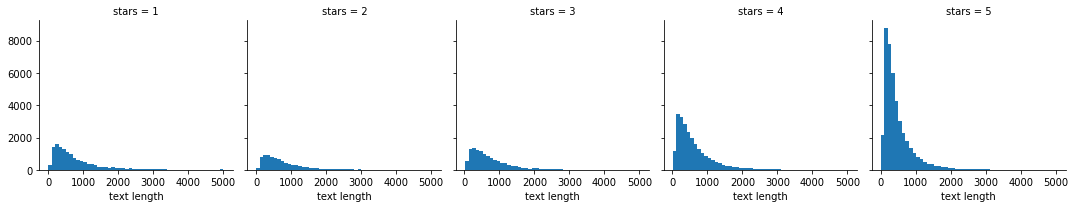

In [6]:
#using Facet Grid, check distribution of each start rating
g = sns.FacetGrid(data=yelp_df, col='stars')
g.map(plt.hist, 'text length', bins=50)

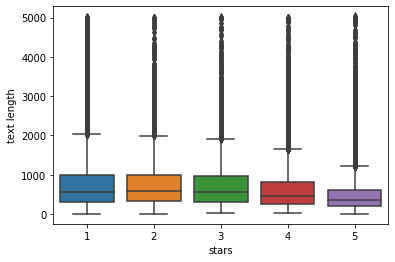

In [7]:
#box plot for each star rating 
sns.boxplot(x='stars', y='text length', data=yelp_df)

In [8]:
stars = yelp_df.groupby('stars').mean()
stars.corr()

,useful,funny,cool,text length
useful,1.000000,0.875657,-0.699303,0.707894
funny,0.875657,1.000000,-0.587496,0.947146
cool,-0.699303,-0.587496,1.000000,-0.592659
text length,0.707894,0.947146,-0.592659,1.000000


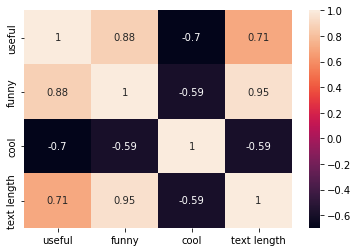

In [9]:
sns.heatmap(data=stars.corr(), annot=True)

In [10]:
#independant and dependant vars
yelp_class = yelp_df[(yelp_df['stars'] == 1) | (yelp_df['stars'] == 5)]
yelp_class.shape



(55986, 10)

In [21]:
# let’s create the X and y for our classification task. X will be the text column of yelp_class, and y will be the stars column.
X = yelp_class['text']
y = yelp_class['stars']

In [14]:
#Sample comment
X[1]

"Small unassuming place that changes their menu every so often. Cool decor and vibe inside their 30 seat restaurant. Call for a reservation. \n\nWe had their beef tartar and pork belly to start and a salmon dish and lamb meal for mains. Everything was incredible! I could go on at length about how all the listed ingredients really make their dishes amazing but honestly you just need to go. \n\nA bit outside of downtown montreal but take the metro out and it's less than a 10 minute walk from the station."

In [12]:
#using NLTK for text-preprocessing
import string
def text_process(text):
  '''
  Takes in a string of text, then performs the following:
  1. Remove all punctuation
  2. Remove all stopwords
  3. Return the cleaned text as a list of words
  '''
  nopunc = [char for char in text if char not in string.punctuation]
  nopunc = ''.join(nopunc)

  return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
sample_text = "Hey there! This is a sample review, which happens to contain punctuations."
print(text_process(sample_text))

['Hey', 'sample', 'review', 'happens', 'contain', 'punctuations']


In [15]:
#Vectorization

bow_transformer = CountVectorizer(analyzer=text_process).fit(X)

In [25]:
X2 = bow_transformer.toArray()

AttributeError: ignored

In [ ]:
bow_transformer.vocabulary_


In [29]:
review_25 = X[24]
review_25

TypeError: ignored

In [17]:
bow_25 = bow_transformer.transform([review_25])
bow_25

NameError: ignored

In [ ]:
print(bow_transformer.get_feature_names()[11443])
print(bow_transformer.get_feature_names()[22077])

In [ ]:
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurrences: ', X.nnz)
# Percentage of non-zero values
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print(‘Density: {}’.format((density)))

### Train and Test Data

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

bow_transformer = CountVectorizer(analyzer=text_process).fit(X_train)

bow4 = bow_transformer.transform(X_train)
messages_bow = bow_transformer.transform(X_train)

tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)


In [22]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [27]:
y_train.head()

30721    1
10389    5
78775    5
94148    5
23803    5
Name: stars, dtype: int64

In [36]:
# Building Multinomial Niave bayes Model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(tfidf4, y_train)

MultinomialNB()

### Testing our Model


In [37]:
bow_transformer_test = CountVectorizer(analyzer=text_process).fit(X_test)

bow4_test = bow_transformer.transform(X_test)
messages_bow_test = bow_transformer.transform(X_test)

tfidf_transformer_test = TfidfTransformer().fit(messages_bow_test)
tfidf4_test = tfidf_transformer.transform(bow4_test)

In [46]:
preds = nb.predict(tfidf4_test)

In [47]:
preds.size

16796

In [49]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#Evaluate preds with actual data
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))

[[ 1256  2695]
 [    5 12840]]


              precision    recall  f1-score   support

           1       1.00      0.32      0.48      3951
           5       0.83      1.00      0.90     12845

    accuracy                           0.84     16796
   macro avg       0.91      0.66      0.69     16796
weighted avg       0.87      0.84      0.81     16796



In [ ]:
positive_review = yelp_class['text'][59]
positive_review

In [ ]:
#predicting positive review
positive_review_transformed = bow_transformer.transform([positive_review])
nb.predict(positive_review_transformed)[0]

In [ ]:
#predicting negative review
negative_review = yelp_class['text'][281]
negative_review

In [ ]:
#slightly more negative review
negative_review_transformed = bow_transformer.transform([negative_review])
nb.predict(negative_review_transformed)[0]

In [ ]:
#Another negative review - incorrectly classified due to class imbalance
another_negative_review_transformed = bow_transformer.transform([another_negative_review])
nb.predict(another_negative_review_transformed)[0]